In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import NASNetMobile
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Path dataset
train_csv = "/kaggle/input/butterfly-image-classification/Training_set.csv"
train_folder = "/kaggle/input/butterfly-image-classification/train"

test_csv =  "/kaggle/input/butterfly-image-classification/Testing_set.csv"
test_folder = "/kaggle/input/butterfly-image-classification/test"

# Result path
result_path = f"run/"
os.makedirs(result_path, exist_ok=True)

In [3]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

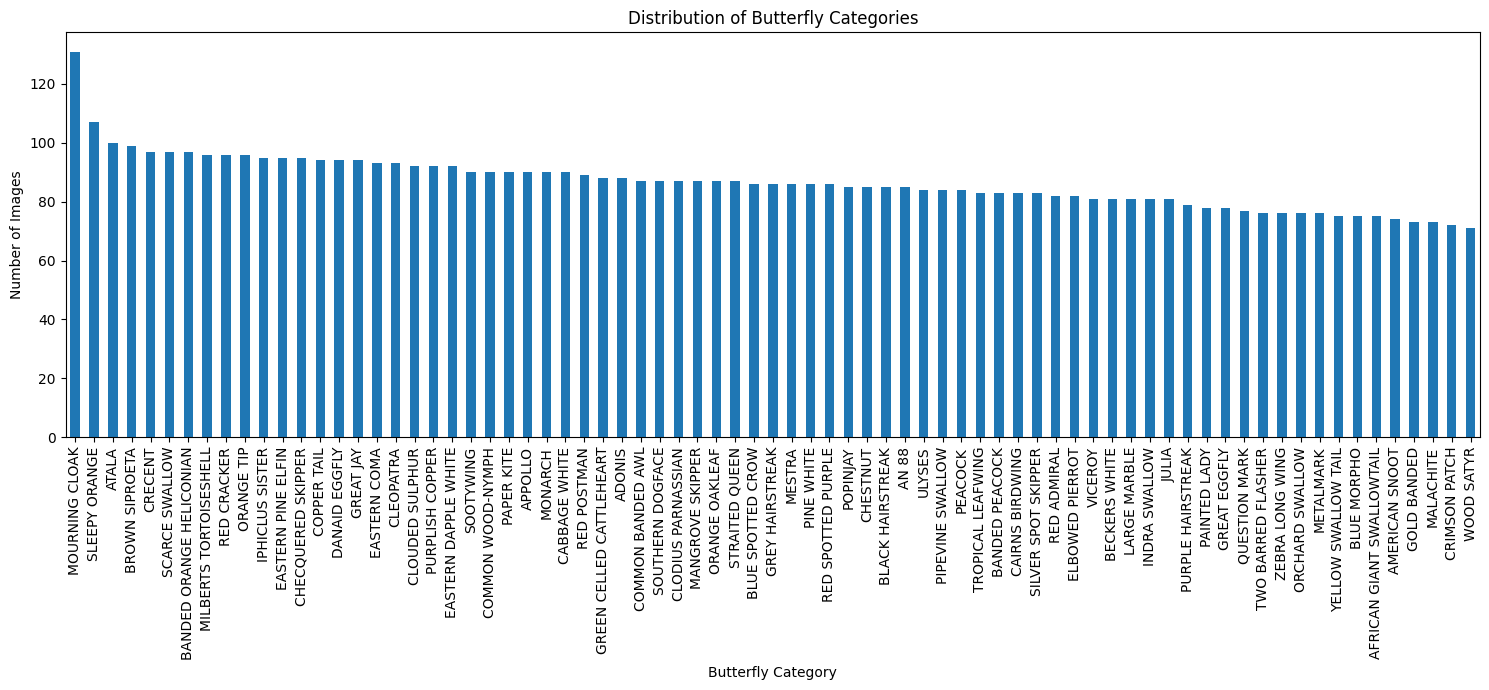

In [4]:
plt.figure(figsize=(15, 7))
train_df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Butterfly Categories')
plt.xlabel('Butterfly Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [5]:
## Hyperparameter
image_size = (224, 224)
batch_size = 32
epochs = 25
learning_rate = 0.0001

In [6]:
class_name = list(set(train_df['label']))

features = []
labels = []

for image in tqdm(os.listdir(train_folder), desc="Preprocess Image") :
    # mencari label dalam csv berdasarkan nama file
    label_name = train_df.loc[train_df['filename'] == image, 'label'].values[0]
    image_read = cv2.imread(os.path.join(train_folder, image))
    image_resized = cv2.resize(image_read, image_size)
    image_normalized = image_resized / 255.0
    features.append(image_normalized)
    label = class_name.index(label_name)
    labels.append(label)

Preprocess Image: 100%|██████████| 6499/6499 [01:33<00:00, 69.66it/s]


In [7]:
print(class_name)

['SOUTHERN DOGFACE', 'TWO BARRED FLASHER', 'INDRA SWALLOW', 'MANGROVE SKIPPER', 'METALMARK', 'PURPLE HAIRSTREAK', 'ULYSES', 'CLODIUS PARNASSIAN', 'BANDED ORANGE HELICONIAN', 'QUESTION MARK', 'COMMON WOOD-NYMPH', 'RED CRACKER', 'RED SPOTTED PURPLE', 'ZEBRA LONG WING', 'SCARCE SWALLOW', 'WOOD SATYR', 'EASTERN COMA', 'ATALA', 'CAIRNS BIRDWING', 'CRIMSON PATCH', 'AMERICAN SNOOT', 'MONARCH', 'MILBERTS TORTOISESHELL', 'JULIA', 'ORANGE TIP', 'AFRICAN GIANT SWALLOWTAIL', 'PEACOCK', 'MALACHITE', 'STRAITED QUEEN', 'BANDED PEACOCK', 'CABBAGE WHITE', 'VICEROY', 'BLUE MORPHO', 'IPHICLUS SISTER', 'APPOLLO', 'POPINJAY', 'SLEEPY ORANGE', 'MOURNING CLOAK', 'PAINTED LADY', 'TROPICAL LEAFWING', 'YELLOW SWALLOW TAIL', 'RED POSTMAN', 'BLACK HAIRSTREAK', 'GREEN CELLED CATTLEHEART', 'ORANGE OAKLEAF', 'EASTERN DAPPLE WHITE', 'CLOUDED SULPHUR', 'CHESTNUT', 'ADONIS', 'CHECQUERED SKIPPER', 'BROWN SIPROETA', 'PAPER KITE', 'DANAID EGGFLY', 'COMMON BANDED AWL', 'ELBOWED PIERROT', 'PINE WHITE', 'GREAT JAY', 'GREY HA

In [8]:
print(len(features))
print(len(labels))

features = np.asarray(features)
labels = np.asarray(labels)

6499
6499


In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=True, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=42)

In [10]:
del features
del labels

In [11]:
# Membuat model MobileNet
base_model = NASNetMobile(
    weights='imagenet', 
    include_top=False, 
    input_shape=(image_size[0], image_size[1], 3),
)

# Freeze layer
num_layers_to_train = int(np.ceil(0.1 * len(base_model.layers)))

for layer in base_model.layers[:-num_layers_to_train] :
    layer.trainable = False

# for layer in base_model.layers :
#     layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
predictions = Dense(75, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

19993432/19993432 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv1 (Conv2D)         (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 stem_bn1 (BatchNormalizati  (None, 111, 111, 32)         128       ['stem_conv1[0][0]']          
 on)                                                                                              
                                                                                                  
 activation (Activation)     

In [12]:
model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# checkpoint_path = os.path.join(result_path, "best_model.h5")
# model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)

# Hitung waktu training
start_time = time.time()

# Latih model dengan menggunakan model checkpoint
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data = (X_valid,y_valid),
#     callbacks=[model_checkpoint, early_stopping],
#     callbacks=[model_checkpoint], #tanpa early stop
    batch_size = batch_size,
)

# Hitung waktu training
end_time = time.time()

print("Training Time", end_time - start_time)

Epoch 1/25
143/143 [==============================] - 46s 127ms/step - loss: 6.8194 - accuracy: 0.2269 - val_loss: 5.0220 - val_accuracy: 0.3774
Epoch 2/25
143/143 [==============================] - 12s 81ms/step - loss: 3.6738 - accuracy: 0.6509 - val_loss: 3.7678 - val_accuracy: 0.5538
Epoch 3/25
143/143 [==============================] - 11s 80ms/step - loss: 2.4785 - accuracy: 0.8477 - val_loss: 3.1339 - val_accuracy: 0.5867
Epoch 4/25
143/143 [==============================] - 12s 81ms/step - loss: 1.8498 - accuracy: 0.9376 - val_loss: 2.6567 - val_accuracy: 0.6718
Epoch 5/25
143/143 [==============================] - 11s 80ms/step - loss: 1.4644 - accuracy: 0.9765 - val_loss: 2.4576 - val_accuracy: 0.6615
Epoch 6/25
143/143 [==============================] - 12s 81ms/step - loss: 1.2640 - accuracy: 0.9767 - val_loss: 2.2630 - val_accuracy: 0.6656
Epoch 7/25
143/143 [==============================] - 12s 81ms/step - loss: 1.0611 - accuracy: 0.9892 - val_loss: 2.0686 - val_accuracy

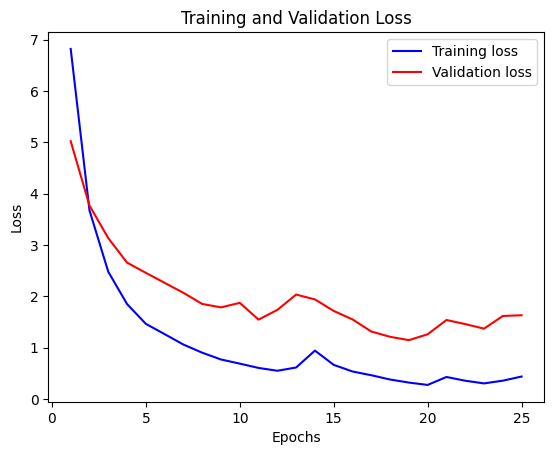

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
loss_image_path = os.path.join(result_path, 'validation loss.png')
plt.savefig(loss_image_path)
plt.show()

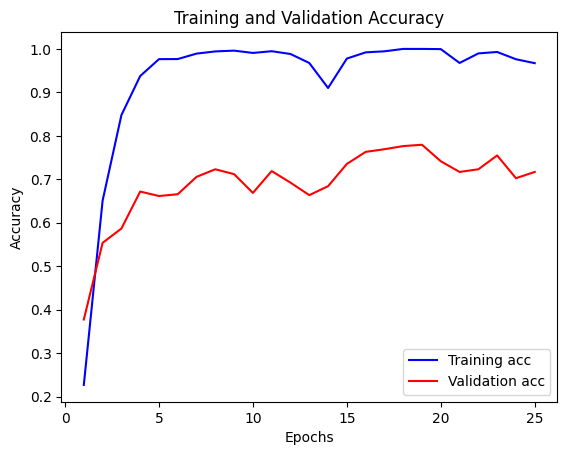

In [14]:
acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
acc_image_path = os.path.join(result_path, 'validation accuracy.png')
plt.savefig(acc_image_path)
plt.show()

In [15]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)

classification_rep = classification_report(y_test, y_pred, target_names=class_name, digits=4)
print("Classification Report:\n", classification_rep)

classification_file = 'classification_report.txt'
with open(classification_file, 'w') as file:
    file.write(classification_rep)

31/31 [==============================] - 6s 54ms/step
Classification Report:
                            precision    recall  f1-score   support

         SOUTHERN DOGFACE     0.4444    0.7273    0.5517        11
       TWO BARRED FLASHER     1.0000    0.2727    0.4286        11
            INDRA SWALLOW     0.8000    0.4444    0.5714         9
         MANGROVE SKIPPER     0.8750    0.8750    0.8750         8
                METALMARK     0.2500    0.8462    0.3860        13
        PURPLE HAIRSTREAK     0.5000    0.4545    0.4762        11
                   ULYSES     1.0000    0.5000    0.6667        12
       CLODIUS PARNASSIAN     0.7000    0.7778    0.7368         9
 BANDED ORANGE HELICONIAN     0.6429    0.6923    0.6667        13
            QUESTION MARK     0.5000    0.6667    0.5714        15
        COMMON WOOD-NYMPH     0.8182    1.0000    0.9000         9
              RED CRACKER     1.0000    0.5000    0.6667        16
       RED SPOTTED PURPLE     0.5833    1.0000    